In [1]:
from wingflattenfuncs import P2, P3
from wingflattenfuncs import WingShape
from wingflattenfuncs import loadwingtrimlinesDeprecated, trimlinestopolygons, exportpolygonsobj

import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
print("Parametrization in uv: ", wingshape.urange, wingshape.vrange)
# approximately flat and in metres (based around section 7) without the compression at the leading edge

Parametrization in uv:  (0, 6.11206792886613) (-1.377293405726668, 1.377293405726668)


In [2]:
import re, json

class ParamPolyGraph:
    def __init__(self, wingshape, trimfile, deprecatedTrimFile=False):
        self.legsampleleng = 0.05
        self.splineweight = 0.21
        self.wingshape = wingshape
        if deprecatedTrimFile:
            snodes, self.paths = loadwingtrimlinesDeprecated(trimfile)
            self.nodes = dict((n, self.wingshape.sevalconvO(p))  for n, p in snodes.items())  
        else:
            jdata = json.load(open(trimfile))
            self.nodes = dict((nn, P2(*p))  for nn, p in jdata["nodes"].items())
            self.paths = jdata["paths"]
        self.Inodemax = max(int(re.sub("[^\d]", "", nn) or "0")  for nn in self.nodes)
    def saveas(self, trimfile):
        json.dump({"nodes":self.nodes, "paths":self.paths}, open(trimfile, "w"))
        
    def closestnodedist(self, mp):
        return min(((mp - p).Len(), nn)  for nn, p in self.nodes.items())
    def pointsdata(self):
        return zip(*self.nodes.values())
    def legsdata(self):
        return [[self.nodes[self.paths[i]], self.nodes[self.paths[i+1]]]  for i in range(0, len(self.paths), 2)]
    def commitlineedit(self, n1, n2):
        for i in range(0, len(self.paths), 2):
            if (n1 == self.paths[i] and n2 == self.paths[i+1]) or (n1 == self.paths[i+1] and n2 == self.paths[i]):
                del self.paths[i:i+2]
                return
        self.paths.extend([n1, n2])
    def delnode(self, n1):
        for i in range(0, len(self.paths), 2):
            while i < len(self.paths) and (n1 == self.paths[i] or n1 == self.paths[i+1]):
                del self.paths[i:i+2]
        del self.nodes[n1]
    def newnode(self, n1, mp):
        n2 = None
        while n2 is None or n2 in self.nodes:
            self.Inodemax += 1
            n2 = "i%d" % self.Inodemax
        self.nodes[n2] = mp
        self.paths.extend([n1, n2])
        return n2
        
    def tangentvec(self, n1, n2):
        vn = P2.ZNorm(self.nodes[n2] - self.nodes[n1])
        if len(self.neighbournodes[n1]) == 2 and not self.wingshape.uvonboundary(self.nodes[n1]):
            i = self.neighbournodes[n1].index(n2)
            nb = self.neighbournodes[n1][1-i]
            vb = P2.ZNorm(self.nodes[n1] - self.nodes[nb])
            vn = P2.ZNorm(vn + vb)
        return vn

    def splinemidnodesitem(self, n0, n1):
        p0 = self.nodes[n0]
        p1 = self.nodes[n1]
        sleg = [ ]
        m0 = self.tangentvec(n0, n1)*self.splineweight
        m1 = -self.tangentvec(n1, n0)*self.splineweight
        N = max(1, int((p0 - p1).Len()/self.legsampleleng + 0.75))
        for i in range(1, N):
            t = i*1.0/N
            t2 = t*t
            t3 = t2*t
            p = p0*(2*t3 - 3*t2 +1) + m0*(t3 - 2*t2 + t) + p1*(-2*t3 + 3*t2) + m1*(t3 - t2)
            sleg.append(p)
        return ((n0, n1), sleg)

    def makeallsplinemidnodes(self):
        self.neighbournodes = dict((nn, [])  for nn in self.nodes)
        for i in range(0, len(self.paths), 2):
            self.neighbournodes[self.paths[i]].append(self.paths[i+1])
            self.neighbournodes[self.paths[i+1]].append(self.paths[i])
        self.splinemidnodes = dict(self.splinemidnodesitem(self.paths[i], self.paths[i+1])  for i in range(0, len(self.paths), 2))
    def getsplinemidnodes(self, n0, n1):
        return self.splinemidnodes[(n0, n1)] if (n0, n1) in self.splinemidnodes  else reversed(self.splinemidnodes[(n1, n0)])
    def splineinterpseqq(self, n0, n1):
        p0 = self.nodes[n0]
        p1 = self.nodes[n1]
        sleg = [ p0 ]
        sleg.extend(self.getsplinemidnodes(n0, n1))
        sleg.append(p1)
        return sleg
    
    def splineinterplegsdata(self):
        self.makeallsplinemidnodes()
        self.neighbournodes = dict((nn, [])  for nn in self.nodes)
        for i in range(0, len(self.paths), 2):
            self.neighbournodes[self.paths[i]].append(self.paths[i+1])
            self.neighbournodes[self.paths[i+1]].append(self.paths[i])
        return [ self.splineinterpseqq(self.paths[i], self.paths[i+1])  for i in range(0, len(self.paths), 2) ]

    def isinnerpoly(self, poly, nodepoints):
        jbl = 0
        ptbl = nodepoints[poly[jbl]]
        for j in range(1, len(poly)):
            pt = nodepoints[poly[j]]
            if pt.v < ptbl.v or (pt.v == ptbl.v and pt.u < ptbl.u):
                jbl = j
                ptbl = pt
        ptblFore = nodepoints[poly[(jbl+1)%len(poly)]]
        ptblBack = nodepoints[poly[(jbl+len(poly)-1)%len(poly)]]
        angFore = P2(ptblFore.u-ptbl.u, ptblFore.v-ptbl.v).Arg()
        angBack = P2(ptblBack.u-ptbl.u, ptblBack.v-ptbl.v).Arg()
        return (angBack < angFore)
    
    def derivepolygons(self):
        nodepoints = self.nodes
        onepathpairs = self.paths
        Lpathvectorseq = { } 
        for i in nodepoints.keys():
            Lpathvectorseq[i] = [ ]  # [ (arg, pathindex) ]
        Npaths = int(len(onepathpairs)/2)
        opvisits2 = [ ]
        for i in range(Npaths):
            i0 = onepathpairs[i*2]
            i1 = onepathpairs[i*2+1]
            if i0 != i1:
                vec = nodepoints[i1] - nodepoints[i0]
                Lpathvectorseq[i0].append([vec.Arg(), i])
                Lpathvectorseq[i1].append([(-vec).Arg(), i])
                opvisits2.append(0)
                opvisits2.append(0)
            else:
                print("Suppressing loop edge in onepathpairs (how did it get here?) polynet function would fail as it relies on orientation")
                opvisits2.append(-1)
                opvisits2.append(-1)

        for pathvectorseq in Lpathvectorseq.values():
            pathvectorseq.sort()

        polys = [ ]
        linearpaths = [ ]
        outerpoly = None
        assert (len(opvisits2) == len(onepathpairs))
        for i in range(len(opvisits2)):
            if opvisits2[i] != 0:
                continue
            ne = int(i/2)
            np = onepathpairs[ne*2 + (0 if ((i%2)==0) else 1)]
            poly = [ ]
            singlenodeindexes = [ ]
            hasnondoublenodes = False
            while (opvisits2[ne*2 + (0 if onepathpairs[ne*2] == np else 1)]) == 0:
                opvisits2[ne*2 + (0 if onepathpairs[ne*2] == np else 1)] = len(polys)+1
                poly.append(np)
                np = onepathpairs[ne*2 + (1  if onepathpairs[ne*2] == np  else 0)]
                if len(Lpathvectorseq[np]) == 1:
                    singlenodeindexes.append(len(poly))
                elif len(Lpathvectorseq[np]) != 2:
                    hasnondoublenodes = True
                for j in range(len(Lpathvectorseq[np])):
                    if Lpathvectorseq[np][j][1] == ne:
                        ne = Lpathvectorseq[np][(j+1)%len(Lpathvectorseq[np])][1]
                        break

            # find and record the orientation of the polygon by looking at the bottom left
            if len(poly) == 0:
                print("bad poly size 0")
                continue

            if not self.isinnerpoly(poly, nodepoints):
                if outerpoly != None:
                    print(" *** extra outer poly ", outerpoly, poly)
                    polys.append(outerpoly) 
                outerpoly = poly
            else:
                polys.append(poly)
        return polys

    
parapolygraph = ParamPolyGraph(wingshape, "segmentedwing.txt", deprecatedTrimFile=True)
#parapolygraph.saveas("test.json")
#parapolygraph = ParamPolyGraph(wingshape, "test.json")


<IPython.core.display.Javascript object>


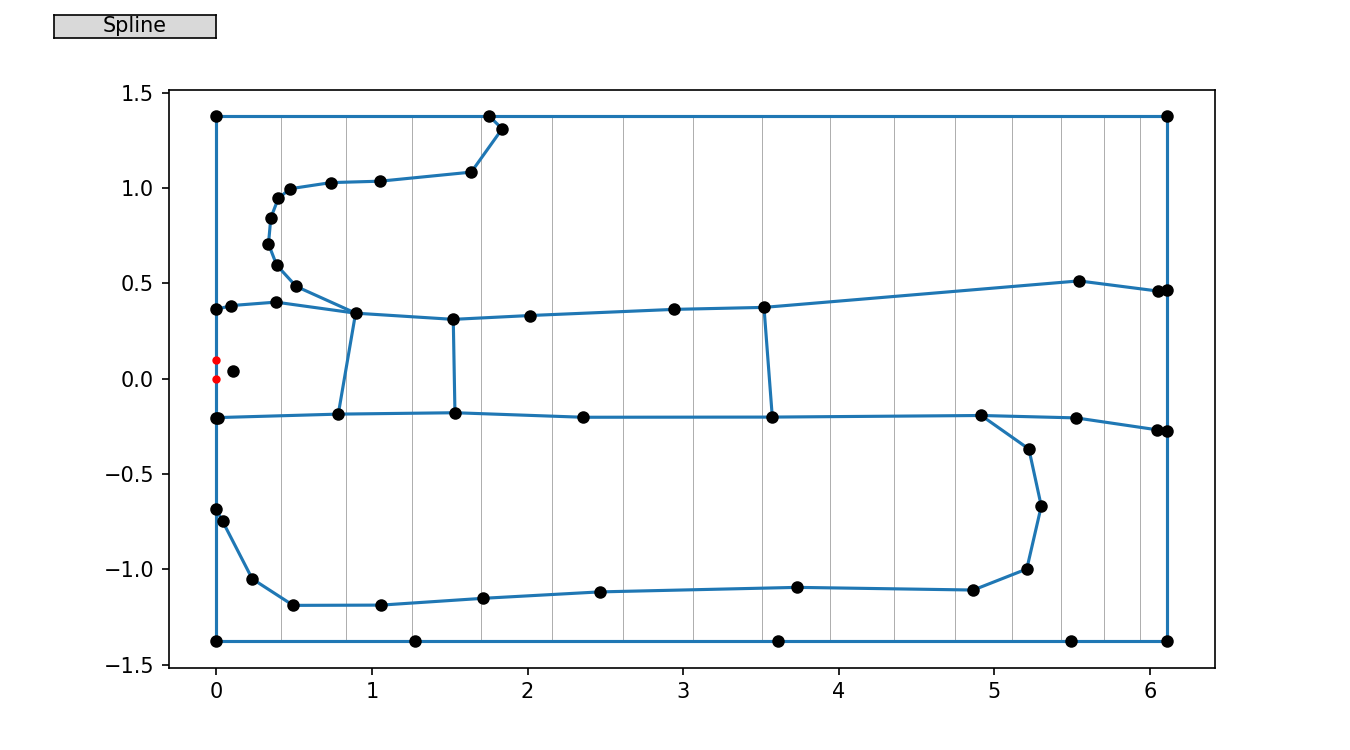

In [3]:
%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

from matplotlib.widgets import Button

cursor1, cursor2 = None, None
def cursordata():
    return zip(*[cursor1 or P2(0,0), cursor2 or P2(0,0.1)])

fig = plt.figure(figsize=(9,5))
axpara = fig.add_subplot(1,1,1)
axpara.add_collection(LineCollection([[(u, wingshape.vrange[0]), (u, wingshape.vrange[1])]  for u in wingshape.leadingedgelengths ], color="grey", linewidth=0.3))

lupdater = axpara.add_collection(LineCollection(parapolygraph.legsdata()))
mupdater, = axpara.plot(*parapolygraph.pointsdata(), color='black', linestyle='none', marker='o', markersize=5)
cursorupdater, = axpara.plot(*cursordata(), color='red', linestyle='none', marker='o', markersize=3)

axpara.autoscale()

events = [ ]
nodenamedown = None
nodeclickdistance = 0.04
Dlineedits = [ ]

def button_press_callback(event):
    global nodenamedown, cursor1, cursor2
    if event.inaxes == axpara:
        mp = wingshape.clampuv(P2(event.xdata, event.ydata))
        l, nn = parapolygraph.closestnodedist(mp)
        if cursor2 is not None:
            if l < nodeclickdistance:
                if nodenamedown == nn:
                    parapolygraph.delnode(nodenamedown)
                nodenamedown = None
                cursor2 = None
            elif nodenamedown is not None:
                nodenamedown = parapolygraph.newnode(nodenamedown, mp)
                Dlineedits.append(("newnode", nodenamedown))
                cursor2 = mp
            mupdater.set_data(parapolygraph.pointsdata())
            lupdater.set_segments(parapolygraph.legsdata())
        elif l < nodeclickdistance:
            if event.button == 1:
                nodenamedown = nn
                cursor1 = None
            elif event.button == 3:
                nodenamedown = nn
                cursor2 = parapolygraph.nodes[nodenamedown]
        cursorupdater.set_data(cursordata())
        fig.canvas.draw_idle()

def button_release_callback(event):
    global nodenamedown, cursor2
    events.append(event)
    if nodenamedown is not None:
        if cursor2 is not None and event.button == 3 and nodenamedown is not None and cursor1 is not None:
            l, nn = parapolygraph.closestnodedist(cursor1)
            if l < nodeclickdistance and nodenamedown != nn:
                parapolygraph.commitlineedit(nodenamedown, nn)
                lupdater.set_segments(parapolygraph.legsdata())
            nodenamedown = None
            cursor2 = None
        elif event.button == 1 and cursor2 is None:
            nodenamedown = None
        cursorupdater.set_data(cursordata())
        fig.canvas.draw_idle()

        
def motion_notify_callback(event):
    global cursor1
    if event.inaxes == axpara:
        mp = wingshape.clampuv(P2(event.xdata, event.ydata))
        if nodenamedown is not None and cursor2 is None:
            parapolygraph.nodes[nodenamedown] = mp
            mupdater.set_data(parapolygraph.pointsdata())
            lupdater.set_segments(parapolygraph.legsdata())
            fig.canvas.draw_idle()
        else:
            cursor1 = mp
            cursorupdater.set_data(cursordata())
            fig.canvas.draw_idle()

        
def buttonSpline(event):
    lupdater.set_segments(parapolygraph.splineinterplegsdata())
    fig.canvas.draw_idle()

def key_press_callback(event):
    events.append(event)
    
axres = plt.axes([0.04, 0.95, 0.12, 0.03])
bres = Button(axres, 'Spline')
bres.on_clicked(buttonSpline)
fig.canvas.mpl_connect('button_press_event', button_press_callback)
fig.canvas.mpl_connect('button_release_event', button_release_callback)
fig.canvas.mpl_connect('motion_notify_event', motion_notify_callback)
fig.canvas.mpl_connect('key_press_event', key_press_callback)

plt.show()

<IPython.core.display.Javascript object>


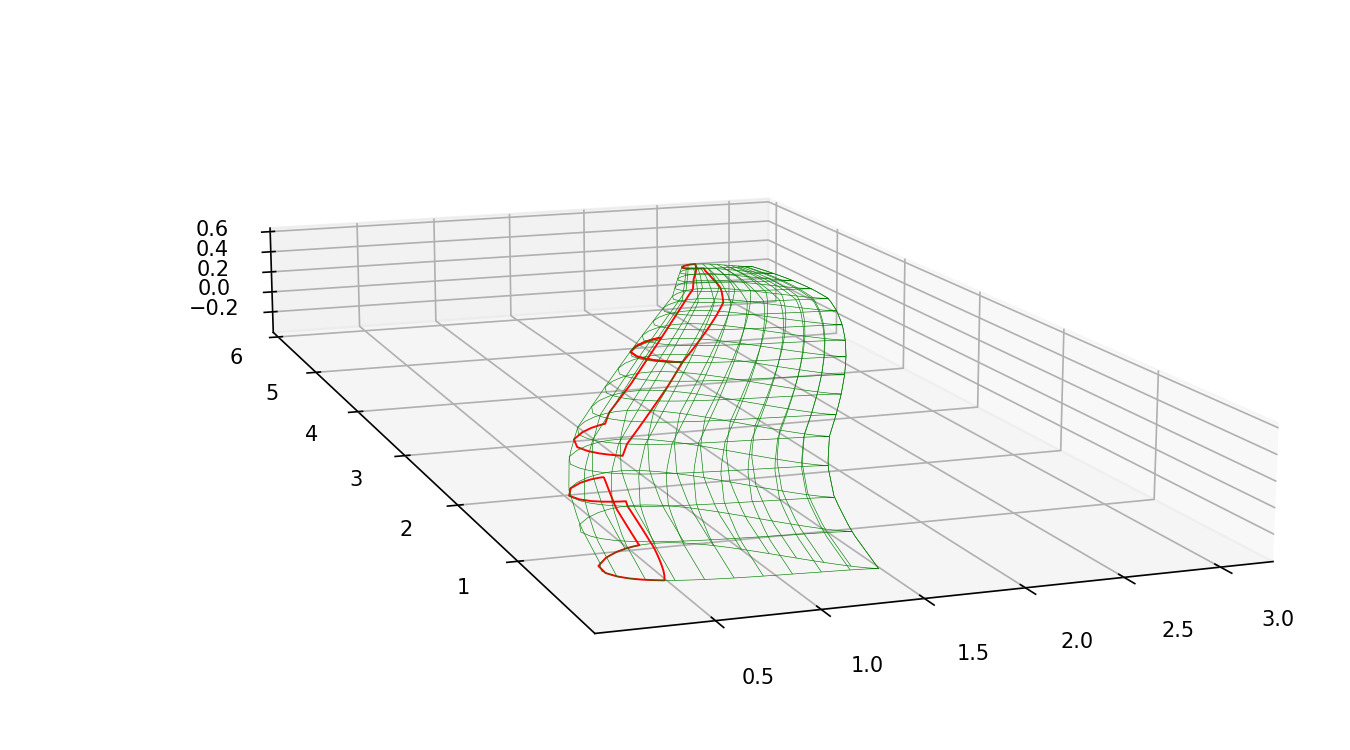

(0.0, 6.0)

In [4]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy

def flipyz(p):
    return P3(p.x, p.z, p.y)

buttonSpline(None)

fig = plt.figure(figsize=(9,5))
ax3d = fig.add_subplot(1,1,1, projection='3d')
ax3d.set_box_aspect([1,2,0.2], zoom=2.3)

seglines = [ [flipyz(wingshape.seval(P2(u,v)))  for v in numpy.linspace(wingshape.vrange[0], wingshape.vrange[1], 51)]  for u in wingshape.leadingedgelengths ]
spanlines = [ [flipyz(wingshape.seval(P2(u,v)))  for u in numpy.linspace(wingshape.urange[0], wingshape.urange[1], 51)]  for v in numpy.linspace(wingshape.vrange[0], wingshape.vrange[1], 21) ]
lc3d = Line3DCollection(seglines+spanlines, color="green", linewidth=0.3)
ax3d.add_collection(lc3d)

polysnodes = parapolygraph.derivepolygons()
segpolys = [ ]
for k in [0, 4, 2]:
    polynodes = polysnodes[k]
    nodes = parapolygraph.nodes
    polyloop = [ ]
    for i in range(len(polynodes)):
        n0 = polynodes[i]
        n1 = polynodes[(i+1) % len(polynodes)]
        polyloop.append(nodes[n0])
        polyloop.extend(parapolygraph.getsplinemidnodes(n0, n1))
    segpolys.append([flipyz(wingshape.seval(p))  for p in polyloop])
    segpolys[-1].append(segpolys[-1][0])
lp3d = Line3DCollection(segpolys, color="red", linewidth=0.9)
ax3d.add_collection(lp3d)



ax3d.set_aspect('auto')
ax3d.set_clip_on(False)
ax3d.autoscale_view()
ax3d.set_xlim3d(-0.1, 3.1)
ax3d.set_zlim3d(-0.5, 0.5)
ax3d.set_ylim3d(0, 6)

In [1]:
import pygmsh


In [3]:
with pygmsh.geo.Geometry() as geom:
    geom.add_polygon(
        [
            [0.0, 0.0],
            [1.0, -0.2],
            [1.1, 1.2],
            [0.1, 0.7],
        ],
        mesh_size=0.1,
    )
    mesh = geom.generate_mesh()

/nix/store/sr711v3q725xxiybwnlfx6167s1zhqy4-python3.9-numpy-1.21.2/lib/python3.9/site-packages/numpy/ctypeslib.py:518: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return asarray(obj)


In [4]:
mesh

<meshio mesh object>
  Number of points: 170
  Number of cells:
    line: 46
    triangle: 292
    vertex: 4